In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sql_queries import main_query
from common_functions import open_connection, translate_products

### **Basic Setup**

#### **Functions**

In [2]:
def missing_value_table(data):
    """Creating Summary Table for Missing Value in Dataset

    Creating Table containing total of missing value and its percentage
    of each feature/column on the dataset.

    Parameters
    ----------
    data : pandas.DataFrame
        The data we want to get the missing value

    Returns
    -------
    table : pandas.DataFrame
        Summary Table for Missing Value
    """
    
    missing_value_count = data.isna().sum()
    missing_value_percent = ((data.isna().sum()/data.count())*100).round(3)

    content = {
            "Missing Data": missing_value_count, 
            "Percentage (%)": missing_value_percent
        }

    table = pd.DataFrame(content)
    return table


In [3]:
def outliers_table(data, col_name, replace=False):
    """Create outliers table and replace outliers
    
    Parameters
    ----------
    data : pandas.DataFrame
        pandas data frame object
    col_name : str
        name of the data frame columns
    replace : bool
        whether outliers would be replaced or not

    Returns
    -------
    outliers : pandas.DataFrame
        the outliers table in data frame
    """

    q1 = data[col_name].quantile(.25)
    q3 = data[col_name].quantile(.75)
    iqr = q3 - q1

    lower_iqr = data[col_name] < q1 - 1.5*iqr
    upper_iqr = data[col_name] > q3 + 1.5*iqr

    if replace:
        new_outliers_value = data[col_name].median()
        data.loc[lower_iqr | upper_iqr, col_name] = new_outliers_value
        data[lower_iqr | upper_iqr][col_name].head()
    else:
        outliers = data[lower_iqr | upper_iqr]
        return outliers


In [4]:
import textwrap


def wrap_labels(ax, width, break_long_words=False):
    """Wrapping Graph xtick value
    
    Parameters:
    -----------
    ax : matplotlib.Axes
        Matplotlib Axes object
    width : int
        Maximum allowed text width
    break_long_words : boolean
        Break text if it is too long
    """
    
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                    break_long_words=break_long_words))
    
    ax.set_xticklabels(labels, rotation=0)

#### **Import Query and Get Basic Info of the Table**

In [5]:
connection = open_connection("olist.db")

Connection is successful


In [6]:
df_main = pd.read_sql(main_query, connection)

In [7]:
print(f"Dataset Shape: {df_main.shape}\n")
df_main.info()

Dataset Shape: (114092, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114092 entries, 0 to 114091
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_id       114092 non-null  object 
 1   order_item_id  113314 non-null  float64
 2   seller_id      113314 non-null  object 
 3   product_name   111702 non-null  object 
 4   price          113314 non-null  float64
 5   review_score   113131 non-null  float64
dtypes: float64(3), object(3)
memory usage: 5.2+ MB


### **Data Processing**

#### **Finding Missing Values**

In [8]:
missing_value_table(df_main)

,Missing Data,Percentage (%)
order_id,0,0.000
order_item_id,778,0.687
seller_id,778,0.687
product_name,2390,2.140
price,778,0.687
review_score,961,0.849


##### Processing - Product Name Missing Value 

In [9]:
df_main[df_main["product_name"].isna()]

,order_id,order_item_id,seller_id,product_name,price,review_score
6,136cce7faa42fdb2cefd53fdc79a6098,1.0,dc8798cbf453b7e0f98745e396cc5616,None,49.90,2.0
122,bfe42c22ecbf90bc9f35cf591270b6a7,1.0,e5a3438891c0bfdb9394643f95273d8e,None,27.30,5.0
212,58ac1947c1a9067b9f416cba6d844a3f,1.0,520b493b57809f446cb0a233bb3e25c7,None,110.00,5.0
264,e22b71f6e4a481445ec4527cb4c405f7,1.0,6cd68b3ed6d59aaa9fece558ad360c0a,None,22.50,4.0
303,a094215e786240fcfefb83d18036a1cd,1.0,c826c40d7b19f62a09e2d7c5e7295ee2,None,122.99,5.0
...,...,...,...,...,...,...
113871,aaab15da689073f8f9aa978a390a69d1,NaN,None,None,NaN,1.0
113903,3a3cddda5a7c27851bd96c3313412840,NaN,None,None,NaN,5.0
113991,a89abace0dcc01eeb267a9660b5ac126,NaN,None,None,NaN,4.0
113992,a69ba794cc7deb415c3e15a0a3877e69,NaN,None,None,NaN,1.0


In [10]:
# Check the missing value on the initial table in the database
product_table_query = """
SELECT
    product_id,
    product_category_name as product_name
FROM olist_products_dataset
"""
df_product_table = pd.read_sql(product_table_query, connection)

df_product_table[df_product_table["product_name"].isna()]

,product_id,product_name
105,a41e356c76fab66334f36de622ecbd3a,None
128,d8dee61c2034d6d075997acef1870e9b,None
145,56139431d72cd51f19eb9f7dae4d1617,None
154,46b48281eb6d663ced748f324108c733,None
197,5fb61f482620cb672f5e586bb132eae9,None
...,...,...
32515,b0a0c5dd78e644373b199380612c350a,None
32589,10dbe0fbaa2c505123c17fdc34a63c56,None
32616,bd2ada37b58ae94cc838b9c0569fecd8,None
32772,fa51e914046aab32764c41356b9d4ea4,None


In [11]:
# Replacing Missing Value in the product_name column
df_main["product_name"].fillna("Unknown", inplace=True)

missing_value_table(df_main)

,Missing Data,Percentage (%)
order_id,0,0.000
order_item_id,778,0.687
seller_id,778,0.687
product_name,0,0.000
price,778,0.687
review_score,961,0.849


##### Processing - seller_id, review_score, price Missing Value 

In [12]:
df_main[df_main["price"].isna()]

,order_id,order_item_id,seller_id,product_name,price,review_score
306,8e24261a7e58791d10cb1bf9da94df5c,NaN,None,Unknown,NaN,1.0
673,c272bcd21c287498b4883c7512019702,NaN,None,Unknown,NaN,3.0
798,37553832a3a89c9b2db59701c357ca67,NaN,None,Unknown,NaN,1.0
857,d57e15fb07fd180f06ab3926b39edcd2,NaN,None,Unknown,NaN,1.0
1304,00b1cb0320190ca0daa2c88b35206009,NaN,None,Unknown,NaN,1.0
...,...,...,...,...,...,...
113871,aaab15da689073f8f9aa978a390a69d1,NaN,None,Unknown,NaN,1.0
113903,3a3cddda5a7c27851bd96c3313412840,NaN,None,Unknown,NaN,5.0
113991,a89abace0dcc01eeb267a9660b5ac126,NaN,None,Unknown,NaN,4.0
113992,a69ba794cc7deb415c3e15a0a3877e69,NaN,None,Unknown,NaN,1.0


In [13]:
df_main.dropna(inplace=True)

missing_value_table(df_main)

,Missing Data,Percentage (%)
order_id,0,0.0
order_item_id,0,0.0
seller_id,0,0.0
product_name,0,0.0
price,0,0.0
review_score,0,0.0


#### **Finding Duplicates**

In [14]:
n_duplicates = df_main.duplicated(keep=False).sum()

print("Number of Duplicates: ", n_duplicates)
df_main[df_main.duplicated(keep=False)]

Number of Duplicates:  794


,order_id,order_item_id,seller_id,product_name,price,review_score
458,ac7a92560a9e99f0a0ab4988102f491b,1.0,b2479f944e1b90cf8a5de1bbfde284d6,cama_mesa_banho,89.99,1.0
459,ac7a92560a9e99f0a0ab4988102f491b,1.0,b2479f944e1b90cf8a5de1bbfde284d6,cama_mesa_banho,89.99,1.0
631,7845a2492ab1b4f2cf3d56c7b8da1446,1.0,4830e40640734fc1c52cd21127c341d4,moveis_decoracao,29.99,5.0
632,7845a2492ab1b4f2cf3d56c7b8da1446,1.0,4830e40640734fc1c52cd21127c341d4,moveis_decoracao,29.99,5.0
707,714fb133a6730ab81fa1d3c1b2007291,1.0,95f83f51203c626648c875dd41874c7f,moveis_decoracao,69.90,1.0
...,...,...,...,...,...,...
113633,2fcdb0c004a2a538d3dd724ea76916bd,1.0,c9c7905cffc4ef9ff9f113554423e671,telefonia,55.00,5.0
113674,dbfa3d8c05cc5d84083fc259a9feb5bc,1.0,6039e27294dc75811c0d8a39069f52c0,eletronicos,129.90,5.0
113675,dbfa3d8c05cc5d84083fc259a9feb5bc,1.0,6039e27294dc75811c0d8a39069f52c0,eletronicos,129.90,5.0
113820,79ce3a0a9eba49ff442b392ab05349a4,1.0,620c87c171fb2a6dd6e8bb4dec959fc6,beleza_saude,69.90,5.0


In [15]:
# Removing duplicates
df_main.drop_duplicates(keep="first", inplace=True)

# Re-check duplicates
n_duplicates = df_main.duplicated(keep=False).sum()

print("Number of Duplicates: ", n_duplicates)
df_main[df_main.duplicated(keep=False)]

Number of Duplicates:  0


,order_id,order_item_id,seller_id,product_name,price,review_score


#### **Handling Outliers**

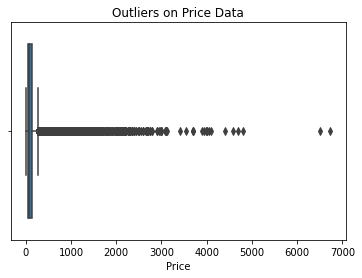

In [16]:
# Create Boxplot
sns.boxplot(x=df_main["price"])

#Modify Graph Info
plt.title("Outliers on Price Data")
plt.xlabel("Price")
plt.show()

In [17]:
outliers = outliers_table(df_main, "price")

print("Number of Outliers: ", outliers["price"].count())
print("Total of Datapoints: ", df_main["price"].count())
print("Outliers to Total Data Percentage: "\
      + f"{round((outliers['price'].count()/df_main['price'].count())*100, 3)}%")

Number of Outliers:  8357
Total of Datapoints:  111973
Outliers to Total Data Percentage: 7.463%


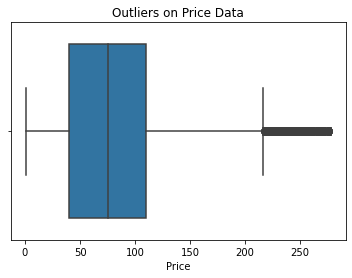

In [18]:
outliers_table(df_main, "price", replace=True)

# Create Boxplot
sns.boxplot(x=df_main["price"])

#Modify Graph Info
plt.title("Outliers on Price Data")
plt.xlabel("Price")
plt.show()

#### **Formatting Data**

In [19]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111973 entries, 0 to 114091
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_id       111973 non-null  object 
 1   order_item_id  111973 non-null  float64
 2   seller_id      111973 non-null  object 
 3   product_name   111973 non-null  object 
 4   price          111973 non-null  float64
 5   review_score   111973 non-null  float64
dtypes: float64(3), object(3)
memory usage: 6.0+ MB


In [20]:
print("Review Score unique value: ", df_main["review_score"].unique())
print("Order Item Id unique value: ", df_main["order_item_id"].unique())

Review Score unique value:  [4. 5. 2. 1. 3.]
Order Item Id unique value:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21.]


In [21]:
# Change review_score data type to integer
df_main["review_score"] = df_main["review_score"].astype(int)
df_main["order_item_id"] = df_main["order_item_id"].astype(int)

# Check data type changes
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111973 entries, 0 to 114091
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_id       111973 non-null  object 
 1   order_item_id  111973 non-null  int32  
 2   seller_id      111973 non-null  object 
 3   product_name   111973 non-null  object 
 4   price          111973 non-null  float64
 5   review_score   111973 non-null  int32  
dtypes: float64(1), int32(2), object(3)
memory usage: 5.1+ MB


##### Translating Product From Portuguese to English

In [22]:
# Checking Table
df_main["product_name"].head()

0    utilidades_domesticas
1               perfumaria
2               automotivo
3                 pet_shop
4                papelaria
Name: product_name, dtype: object

In [23]:
# SQL Query for translation table
query = """
SELECT * FROM product_category_name_translation
"""

#Transform into Pandas DataFrame
df_translation = pd.read_sql(query, connection)
df_translation.head()

,index,product_category_name,product_category_name_english
0,0,beleza_saude,health_beauty
1,1,informatica_acessorios,computers_accessories
2,2,automotivo,auto
3,3,cama_mesa_banho,bed_bath_table
4,4,moveis_decoracao,furniture_decor


In [24]:
# Put each translation column in variable
original_product_name = df_translation["product_category_name"]
product_in_english = df_translation["product_category_name_english"]

# Turn those columns into dictionary
translation_map = dict(zip(original_product_name,  product_in_english))

# Removing the "_" characters
for key in translation_map:
    if "_" in translation_map[key]: 
        translation_map[key] = " ".join(translation_map[key].split("_")).capitalize()
    else:
        translation_map[key] = translation_map[key].capitalize()

df_main.replace(translation_map, inplace=True)
df_main.head()

,order_id,order_item_id,seller_id,product_name,price,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,1,3504c0cb71d7fa48d967e0e4c94d59d9,Housewares,29.99,4
1,53cdb2fc8bc7dce0b6741e2150273451,1,289cdb325fb7e7f891c38608bf9e0962,Perfumery,118.70,4
2,47770eb9100c2d0c44946d9cf07ec65d,1,4869f7a5dfa277a7dca6462dcf3b52b2,Auto,159.90,5
3,949d5b44dbf5de918fe9c16f97b45f8a,1,66922902710d126a0e7d26b0e3805106,Pet shop,45.00,5
4,ad21c59c0840e6cb83a9ceb5573f8159,1,2c9e548be18521d1c43cde1c582c6de8,Stationery,19.90,5


In [25]:
# Re-checking the translated products
products = df_main["product_name"].unique()
not_translated = [product for product in products if "_" in product]
not_translated

['portateis_cozinha_e_preparadores_de_alimentos', 'pc_gamer']

In [26]:
# Adding unformatted and not translated data
translation_map["pc_gamer"] = "PC Gamer" 
translation_map["portateis_cozinha_e_preparadores_de_alimentos"] = "Kitchen and Food Preparation racks"

# Replacing unformatted and not translated data
df_main["product_name"].replace(translation_map, inplace=True)

# Re-checking the 
products = df_main["product_name"].unique()
not_translated = [product for product in products if "_" in product]
not_translated

[]

In [27]:
seller_id = df_main["seller_id"].unique()
seller_name = [f"sellers {i}" for i, _ in enumerate(seller_id)]

new_seller_id = dict(zip(seller_id, seller_name))

df_main["seller_id"].replace(new_seller_id, inplace=True)
df_main.head()

,order_id,order_item_id,seller_id,product_name,price,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,1,sellers 0,Housewares,29.99,4
1,53cdb2fc8bc7dce0b6741e2150273451,1,sellers 1,Perfumery,118.70,4
2,47770eb9100c2d0c44946d9cf07ec65d,1,sellers 2,Auto,159.90,5
3,949d5b44dbf5de918fe9c16f97b45f8a,1,sellers 3,Pet shop,45.00,5
4,ad21c59c0840e6cb83a9ceb5573f8159,1,sellers 4,Stationery,19.90,5


### **Data Analysis**

#### **Use Case 1: Which products are ordered the most and the least?**

In [28]:
df_ordered_products = df_main[
                ["product_name", "order_id"]
        ].groupby("product_name").agg("count")

df_ordered_products.reset_index(inplace=True)
df_ordered_products.head()

,product_name,order_id
0,Agro industry and commerce,212
1,Air conditioning,292
2,Art,207
3,Arts and craftmanship,24
4,Audio,361


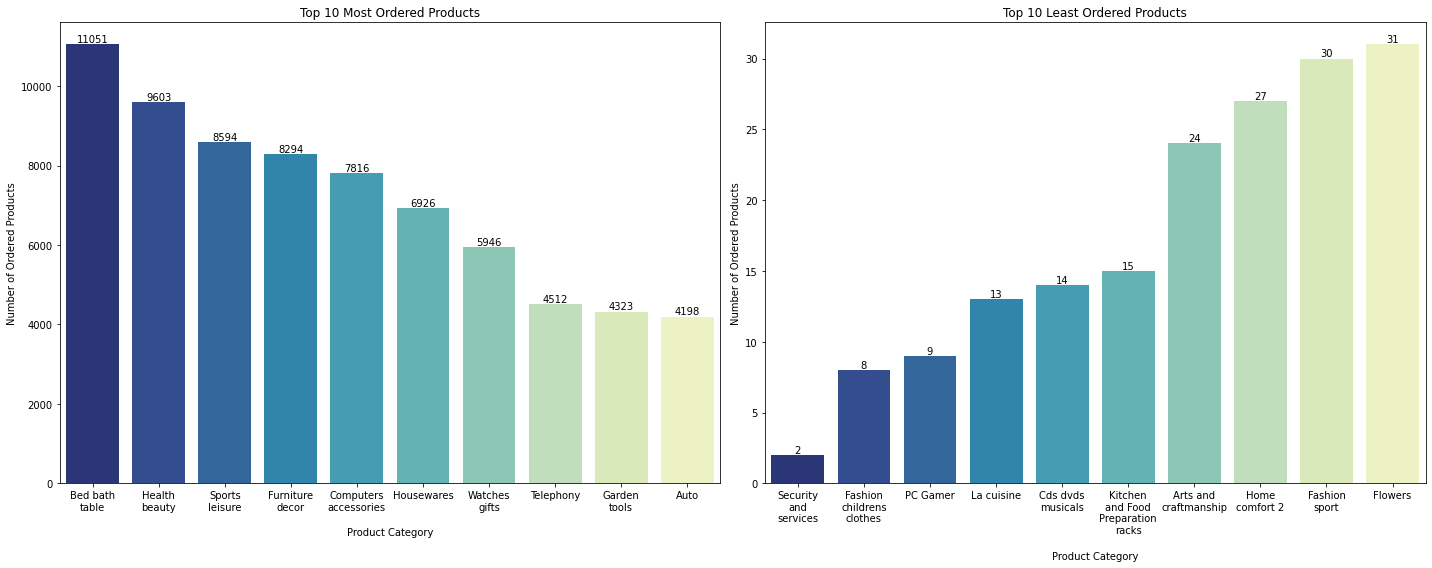

In [29]:
# Setup the Matplotlib Axes
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

for i, _ in enumerate(axes):
    if (i == 0):
        # set the most ordered products
        data = df_ordered_products.sort_values("order_id",
                                               ascending=False)
        bar_title = "Top 10 Most Ordered Products"
    elif (i == 1):
        data = df_ordered_products.sort_values("order_id")
        bar_title = "Top 10 Least Ordered Products"

    sns.barplot(x="product_name", y="order_id", ax=axes[i],
                palette="YlGnBu_r", data=data[:10])

    wrap_labels(axes[i], 10)
    axes[i].bar_label(axes[i].containers[0])
    axes[i].title.set_text(bar_title)
    axes[i].set_xlabel("\nProduct Category")
    axes[i].set_ylabel("Number of Ordered Products")

plt.tight_layout()
plt.show()



In [30]:
df_ordered_products.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
order_id,74.0,1513.148649,2550.951048,2.0,77.25,279.0,1662.0,11051.0


#### **Use Case 2: How Does the Revenue Generated by Each Ordered Products**

In [31]:
df_main["revenue"] = df_main["price"] * df_main["order_item_id"]
df_main.head()

,order_id,order_item_id,seller_id,product_name,price,review_score,revenue
0,e481f51cbdc54678b7cc49136f2d6af7,1,sellers 0,Housewares,29.99,4,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,1,sellers 1,Perfumery,118.70,4,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,1,sellers 2,Auto,159.90,5,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,1,sellers 3,Pet shop,45.00,5,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,1,sellers 4,Stationery,19.90,5,19.90


In [32]:
df_revenue_analysis = df_main[
    ["product_name", "revenue"]
].groupby("product_name").agg("sum")

df_revenue_analysis.reset_index(inplace=True)
df_revenue_analysis.head()

,product_name,revenue
0,Agro industry and commerce,19036.18
1,Air conditioning,43579.96
2,Art,18552.18
3,Arts and craftmanship,1661.40
4,Audio,31332.08


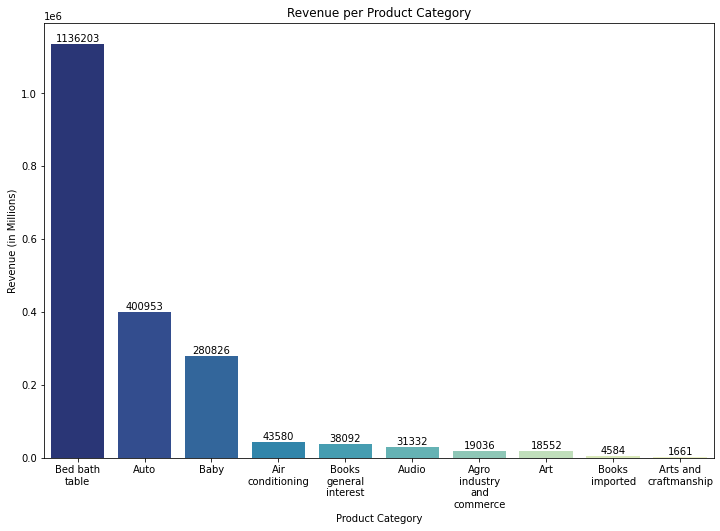

In [33]:
# Create chart
plt.figure(figsize=(12, 8))

ax = sns.barplot(x="product_name", 
                 y="revenue",
                 palette="YlGnBu_r",
                 data=df_revenue_analysis[:10],
                 order=df_revenue_analysis[:10]
                       .sort_values("revenue", 
                                     ascending=False).product_name)  
# Adding data label into the graph
wrap_labels(ax, 10)

# Adding table name and axes labels
plt.bar_label(ax.containers[0], fmt="%.f")
plt.title("Revenue per Product Category")
plt.xlabel("Product Category")
plt.ylabel("Revenue (in Millions)")
plt.show()

In [34]:
df_revenue_analysis.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
revenue,74.0,146139.739865,253667.443013,283.29,6432.56,27793.305,138122.235,1136203.48


#### **Use Case 3: How Does the Proportion of Review Score of the Ordered Products?**

In [35]:
df_review_proportion = df_main[
        ["product_name", "review_score"]
    ].groupby("review_score").agg("count")

df_review_proportion.reset_index(inplace=True)
df_review_proportion.head()

,review_score,product_name
0,1,14192
1,2,3871
2,3,9404
3,4,21267
4,5,63239


In [36]:
percentages = (df_review_proportion["product_name"]\
              / df_review_proportion["product_name"].sum())\
              * 100

df_review_proportion["percentages"] = percentages
df_review_proportion

,review_score,product_name,percentages
0,1,14192,12.674484
1,2,3871,3.457083
2,3,9404,8.398453
3,4,21267,18.992972
4,5,63239,56.477008


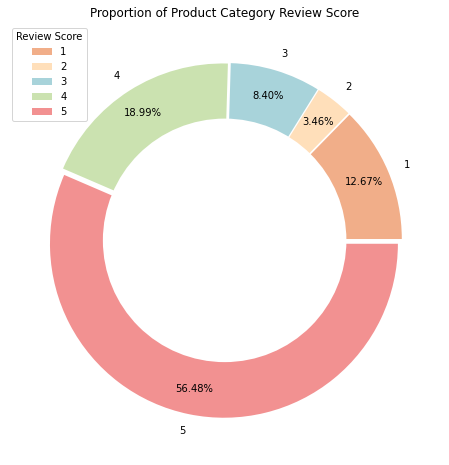

In [37]:
# colors
colors = ['#F1AE89', '#FFDFBa', '#A8D3DA', 
          '#CBE2B0', '#F29191']

# Separator
explode = (0.02, 0.02, 0.02, 0.02, 0.02)

fig, ax = plt.subplots(figsize=(8, 8))

ax.pie(df_review_proportion["percentages"],
       labels=df_review_proportion["review_score"],
       colors=colors, autopct="%.2f%%",
       pctdistance=0.85, explode=explode)

center_circle = plt.Circle((0, 0), 0.70, fc="white")
fig = plt.gcf()

fig.gca().add_artist(center_circle)

plt.title("Proportion of Product Category Review Score")
plt.legend(df_review_proportion["review_score"],
            loc="upper left", title="Review Score")
plt.show()

In [38]:
df_product_review = df_main[
        ["product_name", "review_score", "order_id"]
    ].groupby(["product_name", "review_score"]).agg("count")

df_product_review.reset_index(inplace=True)
df_product_review.head()

,product_name,review_score,order_id
0,Agro industry and commerce,1,27
1,Agro industry and commerce,2,7
2,Agro industry and commerce,3,13
3,Agro industry and commerce,4,57
4,Agro industry and commerce,5,108


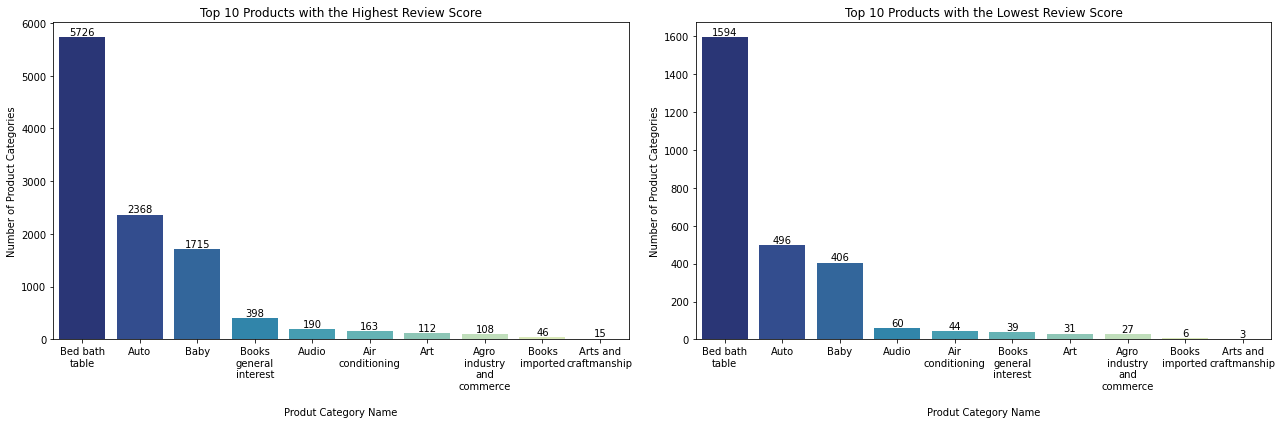

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

for i, _ in enumerate(axes):
    if i == 0:
        high_score = df_product_review["review_score"] == 5
        data = df_product_review[high_score][:10]
        data.sort_values("order_id", ascending=False, inplace=True)
        bar_title = "Top 10 Products with the Highest Review Score"
    elif i == 1:
        low_score = df_product_review["review_score"] == 1
        data = df_product_review[low_score][:10]
        data.sort_values("order_id", ascending=False, inplace=True)
        bar_title = "Top 10 Products with the Lowest Review Score"

    bar_plot = sns.barplot(x="product_name", y="order_id",ax=axes[i],
                            palette="YlGnBu_r",data=data)

    wrap_labels(axes[i], 10)
    axes[i].bar_label(axes[i].containers[0])
    axes[i].title.set_text(bar_title)
    axes[i].set_xlabel("\nProdut Category Name")
    axes[i].set_ylabel("Number of Product Categories")

plt.tight_layout()